# Intel Scenery Classification using Fast.ai library

Let's start this Jupyter notebook with these 3 lines.<br />
Anything starting with % in Jupyter notebook is called a 'magic'. It's not Python code. It's a special Jupyter command.<br/><br/>
The code means the following :-
*   If somebody changes underlying library code while I'm running this, please reload it automatically
*   If somebody asks to plot something, then please plot it here in this Jupyter Notebook

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Let's import the required packages :-

1.   fastai : The deep learning library that sits on top of PyTorch.
For documentation, please visit <a href="docs.fast.ai">docs.fast.ai</a>
2.   fastai.vision : fastai consists of vision as its core application for working with computer vision tasks.
3.   os : To deal with OS-related tasks like reading files, etc.



In [2]:
import os
from fastai import *
from fastai.vision import *

To begin with any deep learning project, we need data. Without data, you can't do something. Kaggle provided an amazing dataset called "Intel Image Classification" hosted by Puneet Bansal. The link is : <a href="https://www.kaggle.com/puneet6060/intel-image-classification">https://www.kaggle.com/puneet6060/intel-image-classification</a><br/><br/>
The dataset is divided into 3 subsets as follows :-

*   seg_train : The training set
*   seg_test : The validation set
*   seg_pred : The test set

Here, I'll be storing their respective paths in separate variables. These paths will be used when I'll create the databunch object during the modelling process.

In [3]:
base_path = Path(os.path.join("..", "input", "intel-image-classification"))
print(base_path.ls(), end="\n\n")

train_path = base_path/'seg_train'/'seg_train'
print(train_path.ls(), end="\n\n")
val_path = base_path/'seg_test'/'seg_test'
print(val_path.ls(),end="\n\n")
pred_path = base_path/'seg_pred'/'seg_pred'
print("No. of test images : {}".format(len(pred_path.ls())))

[PosixPath('../input/intel-image-classification/seg_test'), PosixPath('../input/intel-image-classification/seg_train'), PosixPath('../input/intel-image-classification/seg_pred')]

[PosixPath('../input/intel-image-classification/seg_train/seg_train/glacier'), PosixPath('../input/intel-image-classification/seg_train/seg_train/sea'), PosixPath('../input/intel-image-classification/seg_train/seg_train/street'), PosixPath('../input/intel-image-classification/seg_train/seg_train/mountain'), PosixPath('../input/intel-image-classification/seg_train/seg_train/buildings'), PosixPath('../input/intel-image-classification/seg_train/seg_train/forest')]

[PosixPath('../input/intel-image-classification/seg_test/seg_test/glacier'), PosixPath('../input/intel-image-classification/seg_test/seg_test/sea'), PosixPath('../input/intel-image-classification/seg_test/seg_test/street'), PosixPath('../input/intel-image-classification/seg_test/seg_test/mountain'), PosixPath('../input/intel-image-classification/seg_t

Let's begin with creating the databunch object. DataBunch is an API in the fastai which helps practitioners build data pipelines for the models. Now, this API is subclassed into various specific databunch objects i.e ImageDataBunch works with data of the form of images.<br/>

The ImageDataBunch consists of several factory methods via which you can create your data pipeline. They are listed in this link : <a href="https://docs.fast.ai/vision.data.html#Factory-methods">https://docs.fast.ai/vision.data.html#Factory-methods</a>.<br/>
These methods are defined according to the most common observed patterns via which the data is stored. For instance, if your images are stored in a single directory and the labels are stored in a CSV file, then the method used is :-

```
databunch = ImageDataBunch.from_csv(...)
```

In this case, the images are stored in the 'ImageNet' style directory structure, i.e the labels of the images are the respective directory in which they are stored. That's why we use the following method :-

```
databunch = ImageDataBunch.from_folder(...)
```

There are several parameters that we pass in the factory method. Let's talk about them now.

* <u>path</u> : The path of the base directory i.e where all the image datasets are stored.
* <u>train</u> : The name of the directory which will be the training set of our model.
* <u>valid</u> : The name of the directory which will be the validation set of our model.
* <u>test</u> : The name of the directory which will be the test set of our model.
* <u>seed</u> : Any value which is used in order to obtain reproducible results
* <u>ds_tfms</u> : It stands for data transforms. What it does is apply data augmentation techniques to the image like random zooming, center cropping, changing the contrast of the images, randomly rotating the images by certain degrees, etc. We've used the default values for all this techniques. It works fine for the fine-grained classification.
* <u>bs</u> : It stands for batch size. It means how many images shall be there in each batch in order to be passed to the GPU for further computations.
* <u>size</u> : The size of the images that will be resized into, in terms of pixels. For example, if size = 224, it means that the images will be resized into 224 x 224 pixels.

The other thing that we need to do is normalize the images. Normalizing the images with mean = 0 and standard deviation = 1, will not improve the predictions in general, but also speed up the training process to a great extent. To do this in fast-ai, we do the following :-

```
databunch.normalize(imagenet_stats)
```

In [4]:
data = ImageDataBunch.from_folder(path = base_path,
                                 train = 'seg_train',
                                 valid = 'seg_test',
                                 test = 'seg_pred',
                                 seed = 42,
                                 ds_tfms = get_transforms(),
                                 bs = 32,
                                 size = 224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (14034 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
glacier,glacier,glacier,glacier,glacier
Path: ../input/intel-image-classification;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
glacier,glacier,glacier,glacier,glacier
Path: ../input/intel-image-classification;

Test: LabelList (7301 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../input/intel-image-classification

Next step after creating your data pipeline is to check how the images look before we train our model.

To do this, we use the ```show_batch``` method of ```ImageDataBunch``` object. The methods takes in 2 arguments as follows :-

* rows : The no. of rows of images to be plotted.
* figsize : The size of the figure for each image to will be plotted

The output also consists of the label of the respective image in the title of the figure.

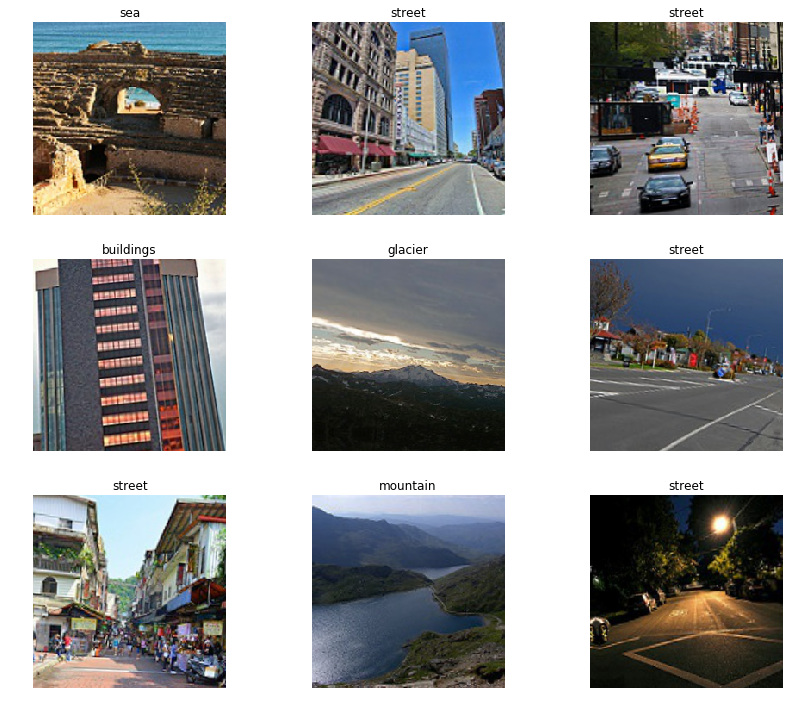

In [5]:
data.show_batch(rows = 3, figsize = (12,10))

Now, we will be starting the data modelling process. It's quite easy when we use the fast-ai library.<br>

The ```cnn_learner``` is an API of the ```vision``` package that is used to build the learner object. The API takes in following parameters :-

* data : The databunch object that will be used for training and validation purposes.
* model : The architecture on which the data will be trained and evaluated. Here, we will be using the ResNet34 architecture for simplification reasons.
* metrics : The metrics/figures that depict the quality of the model predictions, It can ```accuracy```, ```error_rate```,etc.

Fast.ai consists of various model architectures already available. You just need to call the ```models``` API for that and pick any relevant architecture.

The other thing to be noted is that when the learner object is created, the trained model is saved in a directory called 'models' located wherever the image dataset is located.<br>
Now, Kaggle kernels are built in such a way that there's a read-only permission applied to the dataset directory i.e ```/input/kaggle/intel-image-classification```.<br>
We need to change this directory in order to save and load the trained models and avoid retraining the models again and again. So we write the following line after creating the ```learner``` object as follows :-

```
learner.model_dir = "/kaggle/working"
```

When the learner object is being created, the fast-ai library downloads a pretrained model of the requested architecture from the PyTorch framework.

In [6]:
learner = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate])
learner.model_dir = "/kaggle/working/"

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:06<00:00, 14.1MB/s]


The step that you all are waiting for !!! Let's begin the training. All you need is write a single line of code. We'll be writing the following line :-

```
learner.fit_one_cycle(5)
```

What we've done is use one-cycle learning approach of training large neural networks. The paper is located here : <a href="https://arxiv.org/abs/1506.01186">https://arxiv.org/abs/1506.01186</a><br>
The implementation of this concept is already baked in the fast-ai library. With just 5 epochs (or less), you guys can easily create a world-class image classifier without any trouble of making a lot of decisions regarding the selection of hyperparameters and other configuration that you would have to deal with in Keras and TensorFlow.<br><br>

One thing to note is that the tabulated results during the training phase are of the validation set. Fast-ai makes it hard for practitioners to develop a model without any validation set. If we don't use this set, then the model is highly likely to overfit (memorize the images and not learn patters among them).

In [7]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.496892,0.301626,0.894667,0.105333,02:04
1,0.359296,0.248559,0.913000,0.087000,01:52
2,0.294189,0.205774,0.926667,0.073333,01:52
3,0.250912,0.186331,0.932333,0.067667,01:52
4,0.206167,0.184763,0.933333,0.066667,01:53


We can see that we've obtained a whooping 92.6% accuracy !!! Whoa.... that is so cool. Now you don't want to lose all your efforts. Let' save it. It's quite simple.

In [8]:
learner.save('resnet34-stage-1')

We've got excellent results. Let's analyze them if anyone doesn't mind. My advice would be to see them as it'll get you a good sense of how predictions were made and how much correct they are.<br><br>
We'll be using the ```ClassificationInterpretation``` API in order to perform analysis. It's a single line of code that takes in a ```learner``` object and the output will be an ```interpretation``` object which we'll use for further analysis tasks.

In [9]:
interp = ClassificationInterpretation.from_learner(learner)

Let's start with the images that were highly misclassified. To do that, we have the method called ```plot_top_losses```. The parameters to this method are :-

* k : The number of images to plot.
* figsize : The size of the figure for each top loss image.
* heatmap : The visualization displaying which parts of the image activated the predicted class.

The output will be each image having the title of the format <b>prediction/actual/loss/probability</b>. It means :-

* prediction : The predicted class of the image.
* actual : The actual class of the image.
* loss : The value of the loss/error.
* probability : The probability of the actual class when the misclassification occured.

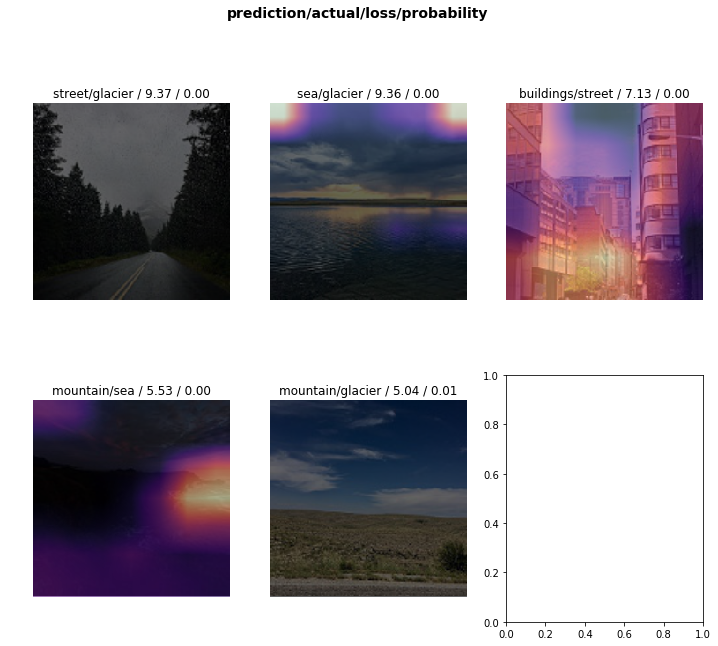

In [10]:
interp.plot_top_losses(5, figsize=(12,10), heatmap = True)

Confusion matrix is another vital piece during model analysis. It helps you give an idea of how many images were clearly identified as correct by the model and how many didn't classify as expected.
The fast-ai library provides a ```plot_confusion_matrix``` method for that purpose.

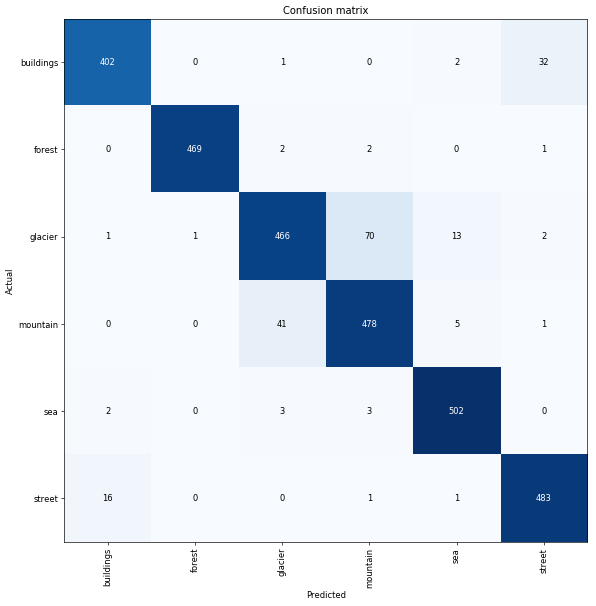

In [11]:
interp.plot_confusion_matrix(figsize=(12,10), dpi=60)

Another crucial piece to identity misclassifications is ```most_confused```. ```most_confused``` is used to identify the possible classes between which the model was 'most-confused'.

In [12]:
interp.most_confused(min_val = 5)

[('glacier', 'mountain', 70),
 ('mountain', 'glacier', 41),
 ('buildings', 'street', 32),
 ('street', 'buildings', 16),
 ('glacier', 'sea', 13),
 ('mountain', 'sea', 5)]

Now ,what if we want to improve our model predictions ? What we need to do is train the model at good learning rates. Learning rates are the parameter that can significantly change the predictions of your model.<br>
Fast-ai provides the code to find a suitable learning rate for our model. We can even visualize the learning rate with the loss generated by our model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.58E-03


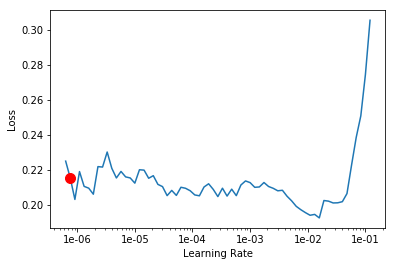

In [13]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

We've got to choose the learning rates. One learning rate will be used to train the initial layers of our model while the other will be used to train the final layers of our model. The range of learning rates will be used by the layers between the initial and final layers.<br><br>
Selecting good LR is challenging here. What we do is select the initial LR only. We select that LR after which the loss increases significantly.<br>
For final layers LR, we'll reduce the previous LR by 10 times. (By default, the LR is 3e-2) i.e we'll use 3e-4 as our LR for the final layers.<br><br>
We first unfreeze the model and retrain the model with the selected learning rates as follows.

In [14]:
learner.unfreeze()
learner.fit_one_cycle(5, max_lr = slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.225601,0.181971,0.933000,0.067000,01:58
1,0.202320,0.171025,0.937000,0.063000,01:58
2,0.160240,0.168779,0.940333,0.059667,01:57
3,0.168797,0.162524,0.939333,0.060667,01:59
4,0.138771,0.167926,0.942667,0.057333,01:57


We see that the new accuracy is 93.63% which has increased by 1%. That's astonishing in itself. Let's quickly save the new model

In [15]:
learner.save('resnet34-stage-2')

We again create our ```ClassificationInterpretation``` object for model analysis.

In [16]:
interp = ClassificationInterpretation.from_learner(learner)

Let's plot the confusion matrix...

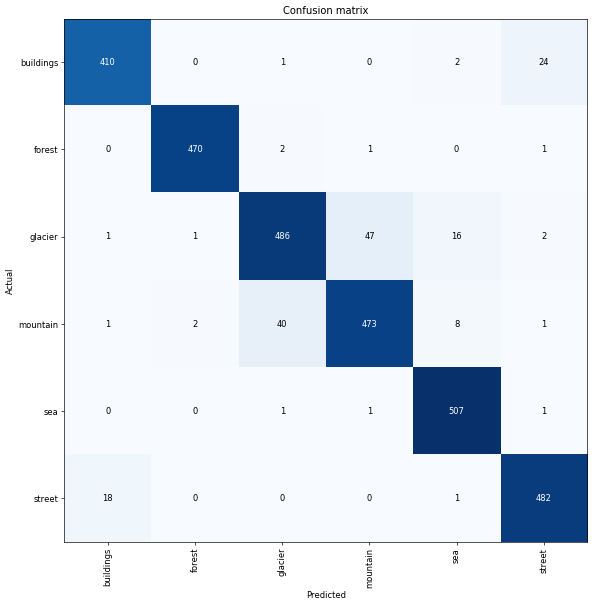

In [17]:
interp.plot_confusion_matrix(figsize = (12,10), dpi = 60)

Let's check out the top losses from our model.

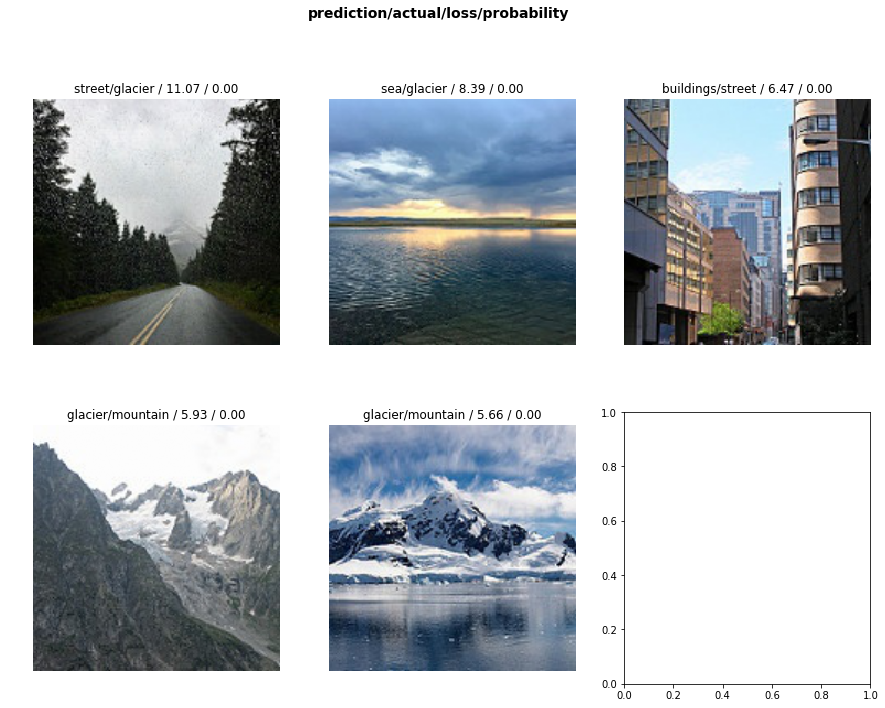

In [18]:
interp.plot_top_losses(5, figsize = (15,11))

Also check the most confused predictions of our model.

In [19]:
interp.most_confused(5)

[('glacier', 'mountain', 47),
 ('mountain', 'glacier', 40),
 ('buildings', 'street', 24),
 ('street', 'buildings', 18),
 ('glacier', 'sea', 16),
 ('mountain', 'sea', 8)]

### Analysis conclusion:
We can clearly see that there is a label noise from our dataset. It's pretty bad. In the last figures regarding the ```plot_top_losses``` code, the forest class was predicted correctly as the image contained only forest image with a deer in it. But the actual label was glacier which is clearly not visible in the image.<br>
Therefore, it can be concluded that these results are pretty much correct. If we remove the label noise, then would be achieve even more correct results.

## CONCLUSION :
We've used fast-ai library to build a world class image classifier that can be used in computer vision challenges like this one.<br>
If you like this notebook, please upvote this. For questions, just comment and I'll respond to you guys.<br><br>
I've also built other tutorials like this. Visit <a href="www.github.com/umangjpatel">my GitHub profile</a>.<br><br>
Adios, I'll see you soon...